In [1]:
import sys
sys.path.append('../src')  # Add source directory to path

In [2]:
from signal_processing.base_signal_processor import BaseSignalProcessor
from signal_processing.motion_artifact_detector import MotionArtifactDetector
from signal_processing.adaptive_filter import AdaptiveFilter
from signal_processing.kalman_filter import KalmanFilter
from signal_processing.wavelet_denoiser import WaveletDenoiser
from signal_processing.pipeline import SignalProcessingPipeline

### Loading Unified Data

In [3]:
processor = BaseSignalProcessor(data_path="../data/processed/cleaned_unified_dataset.parquet")
dataset = processor.load_data()
print(dataset.head())

Loading unified dataset...
                                 bvp  label  subject_id    dataset  \
2020-01-03 08:00:00+00:00   5.673109      0           2  physionet   
2020-01-03 08:00:00+00:00   7.687833      0           2  physionet   
2020-01-03 08:00:00+00:00   1.509560      0           2  physionet   
2020-01-03 08:00:00+00:00  12.999866      0           2  physionet   
2020-01-03 08:00:00+00:00  20.798602      0           2  physionet   

                                 device skin_tone  noise_level     acc_x  \
2020-01-03 08:00:00+00:00   apple_watch      V-VI      0.05088 -0.817685   
2020-01-03 08:00:00+00:00   apple_watch      I-II      0.07712 -0.973498   
2020-01-03 08:00:00+00:00   apple_watch    III-IV      0.06400 -1.054134   
2020-01-03 08:00:00+00:00  galaxy_watch    III-IV      0.09600 -1.000000   
2020-01-03 08:00:00+00:00  galaxy_watch      V-VI      0.07632 -1.000000   

                               acc_y     acc_z  
2020-01-03 08:00:00+00:00 -62.628226  4.996602

In [4]:
import numpy as np

In [5]:
dataset['acc_mag'] = np.sqrt(dataset['acc_x']**2 + dataset['acc_y']**2 + dataset['acc_z']**2)
acc_median = dataset['acc_mag'].median()
acc_iqr = dataset['acc_mag'].quantile(0.75) - dataset['acc_mag'].quantile(0.25)
dataset['acc_mag'] = (dataset['acc_mag'] - acc_median) / (acc_iqr + 1e-6)

### Motion Artifact Detection

In [6]:
detector = MotionArtifactDetector()
dataset = detector.detect_motion_bursts(dataset)
print(dataset[['acc_x', 'acc_y', 'acc_z', 'motion_burst']].head())

                              acc_x      acc_y     acc_z  motion_burst
2020-01-03 08:00:00+00:00 -0.817685 -62.628226  4.996602             0
2020-01-03 08:00:00+00:00 -0.973498 -62.739436  5.184150             0
2020-01-03 08:00:00+00:00 -1.054134 -62.992483  5.020381             0
2020-01-03 08:00:00+00:00 -1.000000 -69.300000  5.000000             0
2020-01-03 08:00:00+00:00 -1.000000 -69.300000  5.000000             0


In [7]:
num_unique_motion_bursts = dataset['motion_burst'].nunique()
motion_burst_counts = dataset['motion_burst'].value_counts()
print(f"Value counts of motion_burst:\n{motion_burst_counts}")

# Check motion burst distribution
motion_burst_counts = dataset['motion_burst'].value_counts(normalize=True) * 100
print(f"Motion Burst Distribution:\n{motion_burst_counts}")


Value counts of motion_burst:
motion_burst
0    6375496
1     179257
Name: count, dtype: int64
Motion Burst Distribution:
motion_burst
0    97.265236
1     2.734764
Name: proportion, dtype: float64


In [8]:
# import matplotlib.pyplot as plt
# # Visualize results
# plt.figure(figsize=(12, 6))
# plt.plot(dataset['acc_mag'], label="Accelerometer Magnitude")
# plt.plot(dataset['motion_burst'] * dataset['acc_mag'].max(), label="Motion Bursts", linestyle='--')
# plt.legend()
# plt.title("Motion Burst Detection")
# plt.show()

### Adaptive Filtering for Motion Artifact Removal

In [9]:
adaptive_filter = AdaptiveFilter()
cleaned_bvp = adaptive_filter.apply_adaptive_filter(
    noisy_signal=dataset['bvp'].values,
    reference_signal=dataset['acc_mag'].values,
    motion_burst=dataset['motion_burst'].values
)
dataset['bvp_cleaned'] = cleaned_bvp

INFO:root:Applying adaptive filtering... Input length: 6554753
INFO:root:Coeffs: [ 4.57572337  9.86010545  9.80114278 12.90653487 16.86762856 17.2181383
 16.47529186 16.8727668  22.92629302 28.69022201], Error: -19.529679070261405
INFO:root:Coeffs: [ 62.23314772  18.66497175 -11.58390344 -55.75541244 -20.10030228
  -7.77727303  -5.97172824  -2.58495721   7.19983958  30.84856957], Error: -12.492944891949772
INFO:root:Coeffs: [ 49.91807681  14.74750909  -8.68202741 -42.99460504 -16.52148167
  -7.11520472  -4.99246495  -2.45593731   5.30676299  23.32788126], Error: -12.353731558909942
INFO:root:Coeffs: [42.03606521 23.35514796 21.90260356  4.82651008 14.87874764 16.52220396
  9.28223444  6.64964094  1.89436532 16.62337695], Error: -179.3635735170215
INFO:root:Coeffs: [ 8.51698085 -2.78670128 -0.09839128 -9.30363391  0.86173828  5.19979814
  4.31344781  1.710864   -2.37407073  4.80229795], Error: -15.244954272535985
INFO:root:Coeffs: [ 5.89209765 -2.01313091  1.5341043  -5.28852472  3.2870

### Apply kalman filter

In [10]:
kalman_filter = KalmanFilter()
bvp_smoothed = kalman_filter.apply_kalman_filter(
    signal=dataset['bvp_cleaned'].values,
    motion_burst=dataset['motion_burst'].values
)
dataset['bvp_smoothed'] = bvp_smoothed

### Wavelet Denoising

In [11]:
# notebooks/phase3_signal_processing.ipynb

wavelet_denoiser = WaveletDenoiser()
denoised_bvp = wavelet_denoiser.apply_wavelet_denoising(dataset['bvp_smoothed'].values,motion_burst=dataset['motion_burst'].values)

# Verify lengths match before assignment
assert len(denoised_bvp) == len(dataset), "Denoised signal length mismatch"

dataset['bvp_denoised'] = denoised_bvp

In [12]:
dataset.head()

,bvp,label,subject_id,dataset,device,skin_tone,noise_level,acc_x,acc_y,acc_z,acc_mag,motion_burst,bvp_cleaned,bvp_smoothed,bvp_denoised
2020-01-03 08:00:00+00:00,5.673109,0,2,physionet,apple_watch,V-VI,0.05088,-0.817685,-62.628226,4.996602,62.832549,0,0.0,0.0,0.008331
2020-01-03 08:00:00+00:00,7.687833,0,2,physionet,apple_watch,I-II,0.07712,-0.973498,-62.739436,5.184150,62.960781,0,0.0,0.0,-0.001601
2020-01-03 08:00:00+00:00,1.509560,0,2,physionet,apple_watch,III-IV,0.06400,-1.054134,-62.992483,5.020381,63.201016,0,0.0,0.0,0.003324
2020-01-03 08:00:00+00:00,12.999866,0,2,physionet,galaxy_watch,III-IV,0.09600,-1.000000,-69.300000,5.000000,69.487337,0,0.0,0.0,0.005598
2020-01-03 08:00:00+00:00,20.798602,0,2,physionet,galaxy_watch,V-VI,0.07632,-1.000000,-69.300000,5.000000,69.487337,0,0.0,0.0,-0.008465


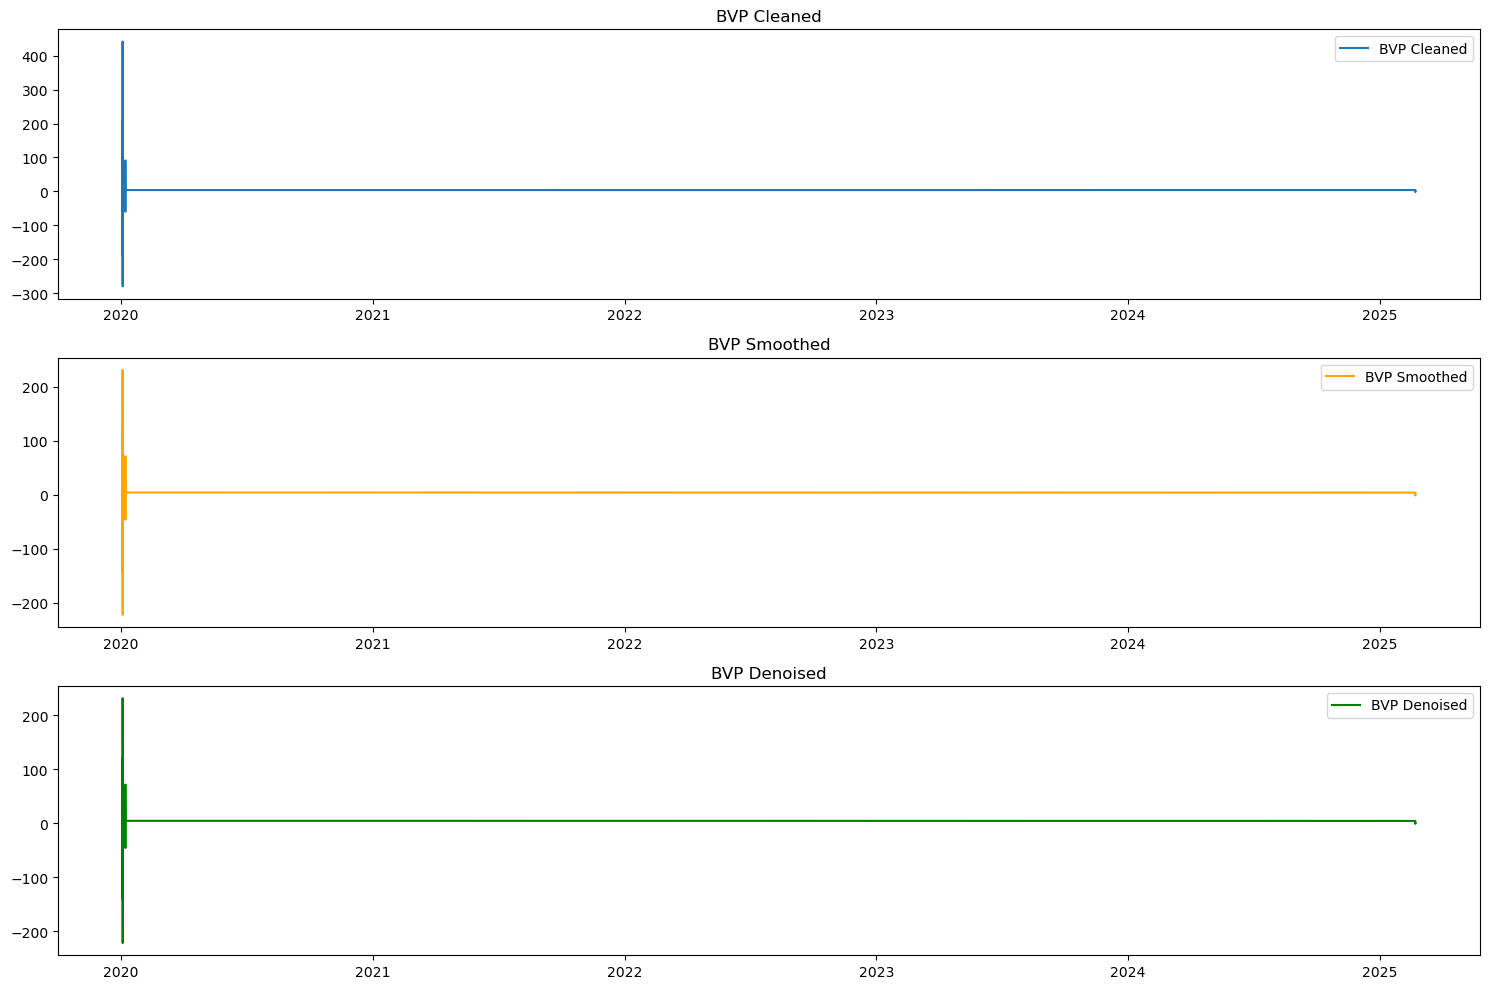

Statistical Properties:
BVP Cleaned: Mean = 3.6165698237174073, Std = 12.31208774490368
BVP Smoothed: Mean = 3.6108073590266696, Std = 10.41435238872683
BVP Denoised: Mean = 3.608472320516038, Std = 10.413564064191805


In [13]:
import matplotlib.pyplot as plt

# Plot the signals
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(dataset.index, dataset['bvp_cleaned'], label='BVP Cleaned')
plt.title('BVP Cleaned')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(dataset.index, dataset['bvp_smoothed'], label='BVP Smoothed', color='orange')
plt.title('BVP Smoothed')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(dataset.index, dataset['bvp_denoised'], label='BVP Denoised', color='green')
plt.title('BVP Denoised')
plt.legend()

plt.tight_layout()
plt.show()

# Statistical properties
print("Statistical Properties:")
print(f"BVP Cleaned: Mean = {dataset['bvp_cleaned'].mean()}, Std = {dataset['bvp_cleaned'].std()}")
print(f"BVP Smoothed: Mean = {dataset['bvp_smoothed'].mean()}, Std = {dataset['bvp_smoothed'].std()}")
print(f"BVP Denoised: Mean = {dataset['bvp_denoised'].mean()}, Std = {dataset['bvp_denoised'].std()}")

## Runnig the Pipeline

In [14]:
import pandas as pd

In [15]:
dataset_ = pd.read_parquet("../data/processed/cleaned_unified_dataset.parquet")
pipeline = SignalProcessingPipeline()
dataset = pipeline.process_signal(dataset_)

INFO:root:Applying adaptive filtering... Input length: 6554753
INFO:root:Coeffs: [ 4.57572337  9.86010545  9.80114278 12.90653487 16.86762856 17.2181383
 16.47529186 16.8727668  22.92629302 28.69022201], Error: -19.529679070261405
INFO:root:Coeffs: [ 62.23314772  18.66497175 -11.58390344 -55.75541244 -20.10030228
  -7.77727303  -5.97172824  -2.58495721   7.19983958  30.84856957], Error: -12.492944891949772
INFO:root:Coeffs: [ 49.91807681  14.74750909  -8.68202741 -42.99460504 -16.52148167
  -7.11520472  -4.99246495  -2.45593731   5.30676299  23.32788126], Error: -12.353731558909942
INFO:root:Coeffs: [42.03606521 23.35514796 21.90260356  4.82651008 14.87874764 16.52220396
  9.28223444  6.64964094  1.89436532 16.62337695], Error: -179.3635735170215
INFO:root:Coeffs: [ 8.51698085 -2.78670128 -0.09839128 -9.30363391  0.86173828  5.19979814
  4.31344781  1.710864   -2.37407073  4.80229795], Error: -15.244954272535985
INFO:root:Coeffs: [ 5.89209765 -2.01313091  1.5341043  -5.28852472  3.2870

In [16]:
dataset.columns

Index(['bvp', 'label', 'subject_id', 'dataset', 'device', 'skin_tone',
       'noise_level', 'acc_x', 'acc_y', 'acc_z', 'acc_mag', 'motion_burst',
       'bvp_cleaned'],
      dtype='object')

### Signal Quality Metrics

In [17]:
import numpy as np

class SignalQualityMetrics:
    def compute_snr(self, clean_signal: np.ndarray, noisy_signal: np.ndarray) -> float:
        """
        Compute the Signal-to-Noise Ratio (SNR) between clean and noisy signals.
        
        Parameters:
            clean_signal (np.ndarray): Clean signal.
            noisy_signal (np.ndarray): Noisy signal.
        
        Returns:
            float: SNR value in dB.
        """
        clean_signal = np.nan_to_num(clean_signal, nan=1e-6)
        noisy_signal = np.nan_to_num(noisy_signal, nan=1e-6)

        mean_signal = np.mean(clean_signal)
        std_noise = np.std(noisy_signal - clean_signal)
        if std_noise == 0:
            return np.inf
        return 20 * np.log10(mean_signal / std_noise)

    def compute_artifact_density(self, motion_bursts: np.ndarray) -> float:
        """
        Compute the artifact density as a percentage of time contaminated by motion artifacts.
        
        Parameters:
            motion_bursts (np.ndarray): Array indicating motion bursts (0 or 1).
        
        Returns:
            float: Artifact density as a percentage.
        """
        if len(motion_bursts) == 0:
            return 0.0
        return np.mean(motion_bursts) * 100

In [18]:
# Compute metrics
metrics_calculator = SignalQualityMetrics()
snr = metrics_calculator.compute_snr(dataset['bvp_cleaned'], dataset['bvp'])
artifact_density = metrics_calculator.compute_artifact_density(dataset['motion_burst'])

print(f"SNR: {snr:.2f} dB, Artifact Density: {artifact_density:.2f}%")

SNR: -18.45 dB, Artifact Density: 2.73%


## Saving cleaned data

In [19]:
pipeline.save_cleaned_dataset(dataset, "../data/cleaned_signal_dataset")

Cleaned dataset saved to ../data/cleaned_signal_dataset
